In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
# from deepxde.backend import tf
# Backend pytorch
import torch
# Backend paddle
# import paddle
import matplotlib.pyplot as plt


C = dde.Variable(2.0)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend tensorflow.compat.v1 or tensorflow
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + tf.exp(-x[:, 1:])
    #     * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    # )
    # Backend pytorch
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )
    # Backend paddle
    # return (
    #     dy_t
    #     - C * dy_xx
    #     + paddle.exp(-x[:, 1:])
    #     * (paddle.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * paddle.sin(np.pi * x[:, 0:1]))
    # )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = func(observe_x)

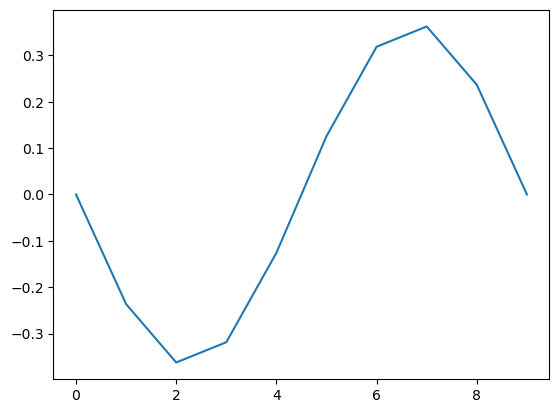

In [3]:
plt.plot(observe_y)

In [7]:
torch.manual_seed(2501)
np.random.seed(2501)

observe_y = dde.icbc.DataPoints(observe_x, func(observe_x), component=0)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=2000,
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C
)
variable = dde.callbacks.VariableValue(C, period=1000)

losshistory, train_state = model.train(iterations=8000, callbacks=[variable])
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.000300 s

Training model...

0         [1.46e+01, 1.06e-01, 7.59e-01, 1.64e-01]    [1.69e+01, 1.06e-01, 7.59e-01, 1.64e-01]    [1.34e+00]    
0 [1.21e+00]


/home/miles/miniforge3/envs/torch/lib/python3.10/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/miles/miniforge3/envs/torch/lib/python3.10/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/miles/miniforge3/envs/torch/lib/python3.10/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was i

1000      [3.28e-03, 2.50e-03, 8.00e-03, 2.91e-03]    [5.00e-03, 2.50e-03, 8.00e-03, 2.91e-03]    [1.97e-01]    
1000 [1.29e+00]
2000      [4.83e-04, 7.13e-04, 1.72e-03, 1.13e-03]    [6.93e-04, 7.13e-04, 1.72e-03, 1.13e-03]    [1.46e-01]    
2000 [1.18e+00]
3000      [1.50e-04, 1.73e-04, 2.07e-04, 2.52e-04]    [3.95e-04, 1.73e-04, 2.07e-04, 2.52e-04]    [7.22e-02]    
3000 [1.08e+00]
4000      [2.38e-04, 1.02e-04, 2.72e-05, 6.48e-05]    [4.30e-04, 1.02e-04, 2.72e-05, 6.48e-05]    [3.22e-02]    
4000 [1.03e+00]
5000      [2.83e-04, 6.58e-05, 9.19e-06, 4.89e-05]    [4.08e-04, 6.58e-05, 9.19e-06, 4.89e-05]    [2.00e-02]    
5000 [1.01e+00]
6000      [5.09e-05, 3.11e-05, 6.38e-06, 2.50e-06]    [1.39e-04, 3.11e-05, 6.38e-06, 2.50e-06]    [8.13e-03]    
6000 [1.01e+00]
7000      [3.19e-05, 1.89e-05, 2.84e-06, 3.57e-06]    [1.10e-04, 1.89e-05, 2.84e-06, 3.57e-06]    [6.04e-03]    
7000 [1.00e+00]
8000      [3.62e-05, 1.41e-05, 2.79e-06, 3.63e-06]    [1.10e-04, 1.41e-05, 2.79e-06, 3.63e-06]   

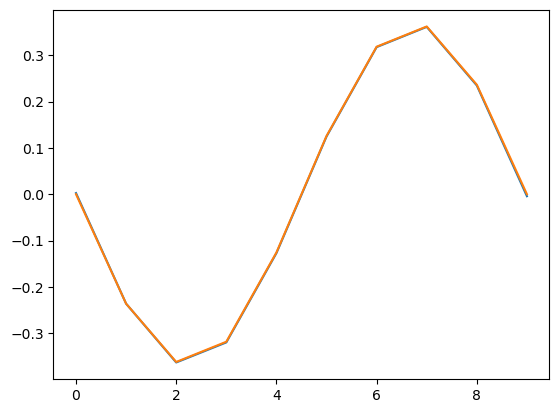

In [8]:
plt.plot(model.predict(observe_x))
plt.plot(func(observe_x))